# **Task 2: Linear Regression Task**

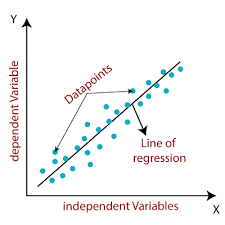

**Linear Regression** is a machine learning algorithm based on supervised learning. It performs a regression task. Regression models a target prediction value based on independent variables. It is mostly used for finding out the relationship between variables and forecasting.

As we are going to predict the price of a house (which is continuous variable), linear regression would be a good choice to consider.


------------

First, we are going to perform linear regression before any processing (standardization and dimensionality reduction)
then, we will perform it after standardization and dimensionality reduction, and compare both results.

## **Before processing (PCA & Scaling)**

Import linear regression from sklearn library

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

Define a function to calculate and present Performance scores
- R2
- Mean squared error
- Mean absolute error
- Root Mean squared error

for each model.

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

def performance_metric(y_true, y_predict): # actual y and the predicted one as parameters

    r2_test = r2_score(y_true, y_predict) #R2 score
    mse_test = mean_squared_error(y_true, y_predict) # Mean squared error
    mae_test = mean_absolute_error(y_true, y_predict) # Mean absolute error
    rmse_test = np.sqrt(mean_squared_error(y_true, y_predict)) # Root Mean squared error

    test_matric = [r2_test, mse_test, mae_test, rmse_test] # matrics contain all scores


    # Return scores
    return test_matric

The above function (**`performance_metric`**) will be used in the below function (**`model_training`**) which take features and target, split them into train and test sets, then fit them to which model is entered as parameter, finally return scores using **`performance_metric`** function as we mentioned before.


In [ ]:
def model_training(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # split into train and test

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # training performance
    model.fit(X_train,y_train)
    train_pred = model.predict(X_train)
    train_scores = performance_metric(y_train, train_pred)

    # testing performance
    test_pred = model.predict(X_test)
    test_scores = performance_metric(y_test, test_pred)

    per_df = pd.DataFrame([train_scores, test_scores])
    per_df.columns = ['R2', 'MSE', 'MAE', 'RMSE']
    per_df.index = ['Train', 'Test']

    # plot actual vs predicted
    plt.scatter(y_test, test_pred)
    plt.title('Actual price vs Predicted price')
    # Return scores
    return per_df

### **Model training**

In this section We will train Linear Regression twice, **`once on the most correlated features`** with the target price, and **`other with all 13 features`**.

then compare results.

---



#### **Train Most correlated features**

##### **The impact of RM squared**

While reading **`"Hedonic Housing Prices and the Demand for Clean Air - 1978"`** paper which is the original paper for this dataset, we noticed in features description section that the paper recommend squaring **RM** feature -represents average number of rooms- because it seems to have better results.
We tested this and found a difference in **R2** score with an increase of **0.3**, so we dicided to use it. ([Paper](https://www.law.berkeley.edu/files/Hedonic.PDF))

In [ ]:
boston_df["RM"] =  boston_df["RM"] ** 2

Splitting data `-that contains Correlated Features-` into features (X) and target (y):

In [ ]:
# specifies inputs and target
X_multi = boston_df_multi.drop('PRICE', axis=1)
y_multi = boston_df_multi['PRICE']

,R2,MSE,MAE,RMSE
Train,0.730857,17.124938,3.109886,4.138229
Test,0.711133,14.756868,2.979907,3.841467


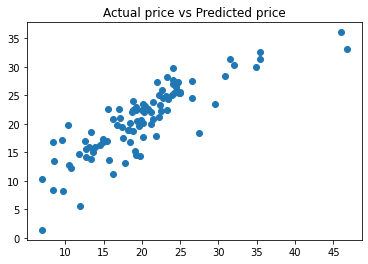

In [ ]:
model_training(lin_reg, X_multi, y_multi) # train linear regression model

Training Linear regression on the most correlated features has given **0.76 R2 score** and **11.83 MSE** on the testing set, thus points in scatter plot aren't as compact as it suppose to be.
We tried to decrease MSE and increase R2 score by performing **Lasso and Ridge** Regression as shown below.

##### **Feature selection**

###### **1- Lasso Regression**

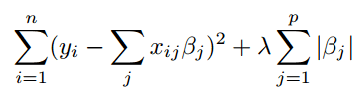

The LASSO method aims to produce a model that has high accuracy and only uses a subset of the original features. The way it does this is by putting in a constraint where the sum of the absolute values of the coefficients is less than a fixed value. To that end it lowers the size of the coefficients and leads to some features having a coefficient of 0. ([Source](https://medium.com/@zawar-ahmed/comparing-linear-regression-models-lasso-vs-ridge-60587ff5a5aa))


---



Here we used **LassoCV** function from `sklearn.linear_model` which has built in cross validation.

,R2,MSE,MAE,RMSE
Train,0.730845,17.125696,3.110290,4.138320
Test,0.710742,14.776826,2.981998,3.844064


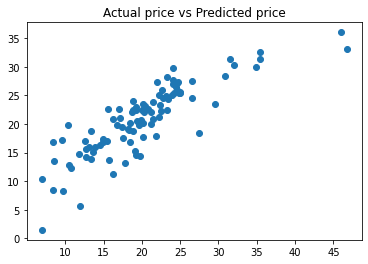

In [ ]:
from sklearn.linear_model import LassoCV
lambda_ = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
lasscv_m = LassoCV(alphas = lambda_, cv =10, normalize = True)
model_training(lasscv_m, X_multi, y_multi)

In [ ]:
alpha_l = lasscv_m.alpha_
alpha_l

0.001

It's noticeable that results has slightly increased, now let's move on to Ridge Regression.

###### **2. Ridge Regression**

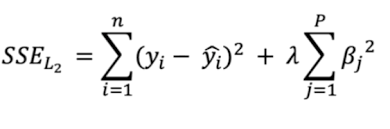

The Ridge Regression method was one of the most popular methods before the LASSO method came about. The idea is similar, but the process is a little different. The Ridge Regression also aims to lower the sizes of the coefficients to avoid over-fitting, but it does not drop any of the coefficients to zero.

,R2,MSE,MAE,RMSE
Train,0.728854,17.252391,3.130092,4.153600
Test,0.711977,14.713771,2.990171,3.835853


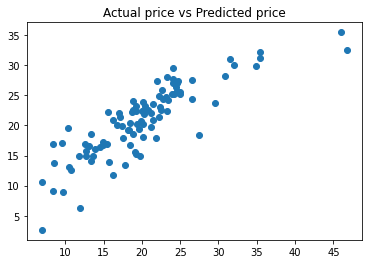

In [ ]:
from sklearn.linear_model import RidgeCV
lambda_ = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
ridgecv_m = RidgeCV(alphas = lambda_, cv=10, normalize = True)
model_training(ridgecv_m, X_multi, y_multi)

In [ ]:
alpha_r = ridgecv_m.alpha_
alpha_r

0.1

Results went down again.

##### **Cross validation**

**Cross-validation** is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. ([check this link](https://docs.aws.amazon.com/machine-learning/latest/dg/cross-validation.html))

In [ ]:
from sklearn.model_selection import cross_val_predict
y_pred_cv = cross_val_predict(lin_reg, X_multi, y_multi, cv=5)

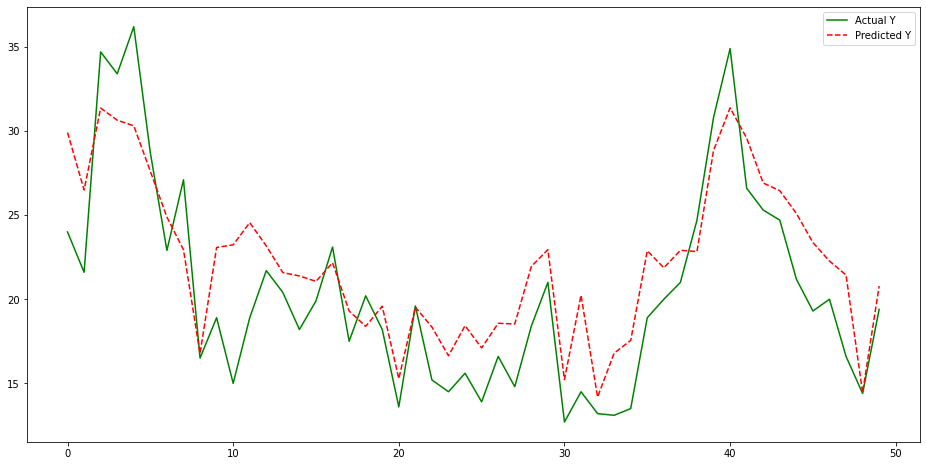

In [ ]:
fig= plt.figure(figsize=(16,8))
plt.plot(y_multi[:50], 'g')
plt.plot(y_pred_cv[:50], 'r--')
plt.legend(['Actual Y', 'Predicted Y'])

In [ ]:
r2_score(y_multi, y_pred_cv)

0.6055121447592182

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, X_multi, y_multi, cv=5)
scores

array([0.65568115, 0.66745226, 0.39917479, 0.11428414, 0.23376705])

#### **Train All the features**

Splitting data into features (X) and target (y):

In [ ]:
X = boston_df.drop(['PRICE'], axis=1)
y = boston_df['PRICE']

,R2,MSE,MAE,RMSE
Train,0.791888,13.241673,2.698194,3.638911
Test,0.782473,11.112451,2.547774,3.333534


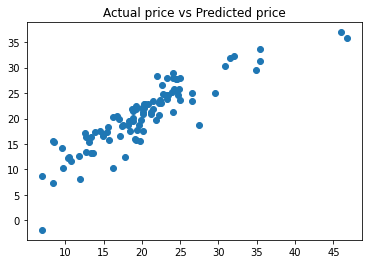

In [ ]:
model_training(lin_reg, X, y)

When we trained Linear Regression model on all the 13 features **R2 has increased by 0.4!**


##### **1- Lasso Regression**

,R2,MSE,MAE,RMSE
Train,0.791888,13.241673,2.698194,3.638911
Test,0.782473,11.112451,2.547774,3.333534


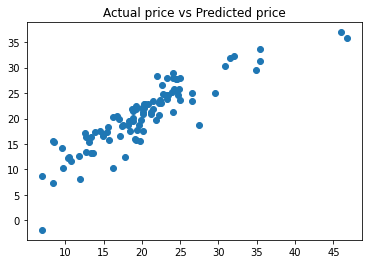

In [ ]:
from sklearn.linear_model import LassoCV
lambda_ = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

lasscv = LassoCV(alphas = lambda_, cv =5, normalize = True)
model_training(lasscv, X, y)


In [ ]:
alpha = lasscv.alpha_
alpha

0.0

##### **2. Ridge Regression**

,R2,MSE,MAE,RMSE
Train,0.791888,13.241673,2.698194,3.638911
Test,0.782473,11.112451,2.547774,3.333534


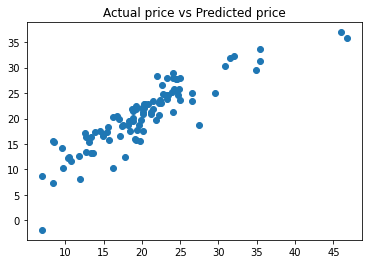

In [ ]:
from sklearn.linear_model import RidgeCV

ridgecv = RidgeCV(alphas = [0, 0.5, 1],cv=5,normalize = True)
model_training(ridgecv, X, y)

In [ ]:
ridgecv.alpha_

0.0

##### **Cross validation**

In [ ]:
from sklearn.model_selection import cross_val_predict
y_pred_cv = cross_val_predict(lin_reg, X, y, cv=5)

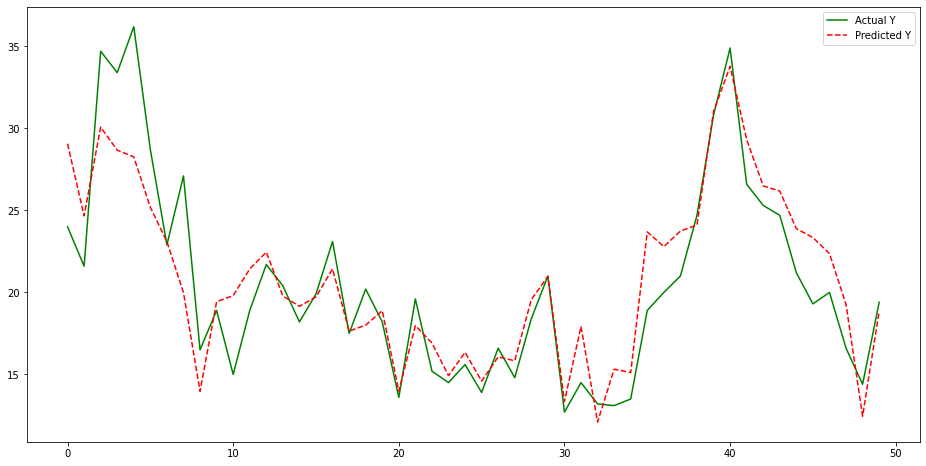

In [ ]:
fig= plt.figure(figsize=(16,8))
plt.plot(y[:50], 'g')
plt.plot(y_pred_cv[:50], 'r--')
plt.legend(['Actual Y', 'Predicted Y'])

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lin_reg, X, y, cv=5)
scores

array([0.70385453, 0.79289319, 0.58994107, 0.10701103, 0.15586806])

## **After processing (PCA & Scaling)**

Previously we use PCA for dimensionality reduction, now we are going to fit it onto Linear regression.

---

Define function for training a model on data.

In [ ]:
def pca_training(model, X_train_pca0, y_train_pca0, X_test_pca0, y_test_pca0):
  model.fit(X_train_pca0, y_train_pca0)
  train_pred = model.predict(X_train_pca0)
  test_pred = model.predict(X_test_pca0)

  per_matric_train = performance_metric(y_train_pca0, train_pred)
  per_matric_test = performance_metric(y_test_pca0, test_pred)

  per_df = pd.DataFrame([per_matric_train, per_matric_test])
  per_df.columns = ['R2', 'MSE', 'MAE', 'RMSE']
  per_df.index = ['Train', 'Test']

  plt.scatter(y_test_pca0, test_pred)
  return per_df

In [ ]:
# get a copy of train, test sets
X_train_pca2 = X_train_pca
y_train_pca2 = y_train_pca
X_test_pca2 = X_test_pca
y_test_pca2 = y_test_pca

In [ ]:
# import linear Regression
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

,R2,MSE,MAE,RMSE
Train,0.734504,16.265003,2.930381,4.032989
Test,0.712095,14.707742,2.927055,3.835067


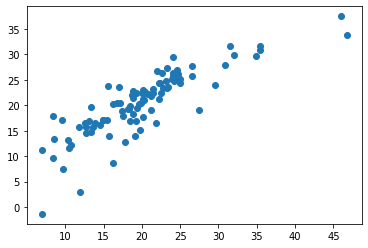

In [ ]:
pca_training(lin_reg, X_train_pca2, y_train_pca2, X_test_pca2, y_test_pca2)

## **Model Selection**


The highest Evaluation matrics has been recorded was when we trained** Linear Regression on All 13 feature**.
that is:

**R2 score: `0.78`**

**MSE: `11.1`**

**MAE: `2.54`**

**RMSE: `3.33`**



---

